<a href="https://colab.research.google.com/github/amityadav108/Project---Food_Delivery_Time_Prediction/blob/main/Project_Food_Delivery_Time_Prediction_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Phase 1: Data Preprocessing ---
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve, auc)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --- Load Dataset ---
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')
print("Initial Data Preview:")
print(df.head(3))

Initial Data Preview:
  Order_ID       Customer_Location     Restaurant_Location  Distance  \
0  ORD0001  (17.030479, 79.743077)  (12.358515, 85.100083)      1.57   
1  ORD0002  (15.398319, 86.639122)  (14.174874, 77.025606)     21.32   
2  ORD0003  (15.687342, 83.888808)  (19.594748, 82.048482)      6.95   

  Weather_Conditions Traffic_Conditions  Delivery_Person_Experience  \
0              Rainy             Medium                           4   
1             Cloudy             Medium                           8   
2              Snowy             Medium                           9   

  Order_Priority Order_Time Vehicle_Type  Restaurant_Rating  Customer_Rating  \
0         Medium  Afternoon          Car                4.1              3.0   
1            Low      Night          Car                4.5              4.2   
2           High      Night         Bike                3.3              3.4   

   Delivery_Time  Order_Cost  Tip_Amount  
0          26.22     1321.10       81.54

In [ ]:
# --- Handle Missing Values ---
# Fill numeric columns with mean and categorical with 'Unknown'
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna('Unknown', inplace=True)

In [ ]:
# --- Create Target Variable ---
# Check which column to use for delivery status
if 'Delivery_Time' in df.columns:
    df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 'Delayed' if x > 30 else 'Fast')
elif 'Status' in df.columns:
    df.rename(columns={'Status': 'Delivery_Status'}, inplace=True)
else:
    raise ValueError("No suitable columns found to create target variable. Please check your CSV.")

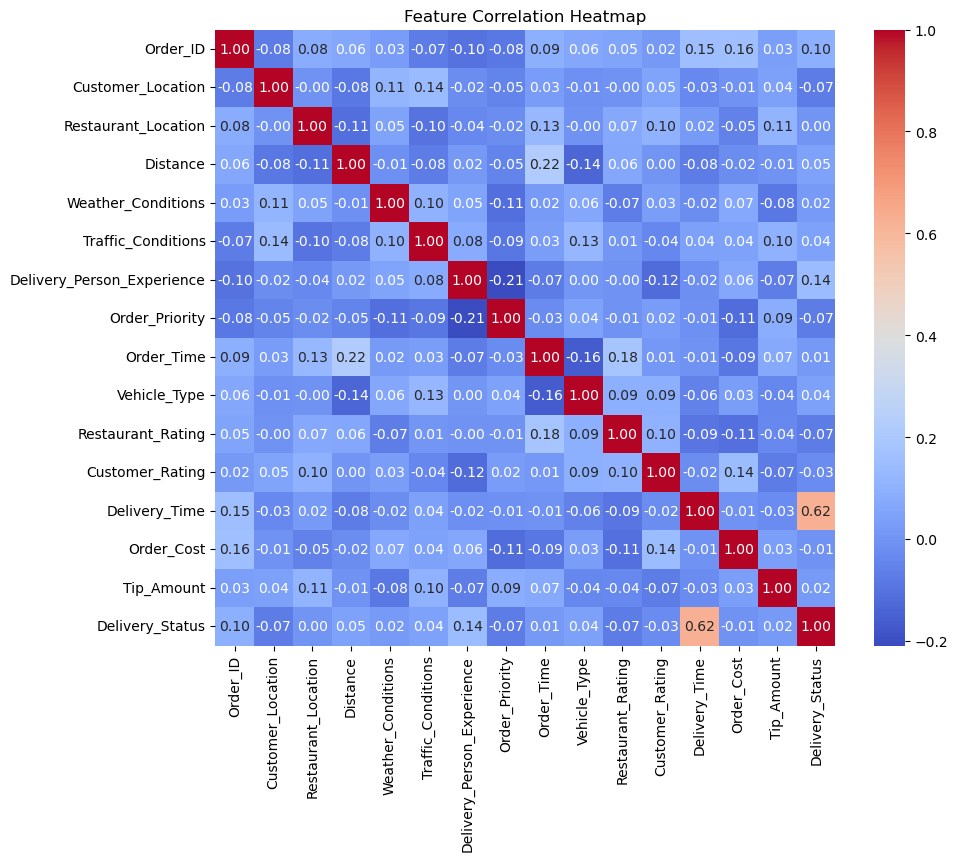

In [ ]:
# --- Encode Categorical Features ---
categorical_cols = df.select_dtypes(include=['object']).columns.drop('Delivery_Status')
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Convert Delivery_Status to numeric temporarily for correlation
df_corr = df.copy()
df_corr['Delivery_Status'] = df_corr['Delivery_Status'].map({'Fast': 0, 'Delayed': 1})

# --- Feature Correlation Visualization ---
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# --- Feature Scaling ---
scaler = StandardScaler()
features = df.drop(columns=['Delivery_Status'])
X = scaler.fit_transform(features)

In [ ]:
# Encode target
y = df['Delivery_Status'].map({'Fast': 0, 'Delayed': 1})

In [ ]:
# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# --- Phase 2: Model Training and Hyperparameter Tuning ---
results = {}
roc_curves = {}

In [ ]:
# 1. Gaussian Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:, 1]
results['Naive Bayes'] = accuracy_score(y_test, y_pred_nb)
roc_curves['Naive Bayes'] = roc_auc_score(y_test, y_prob_nb)

In [ ]:
# 2. K-Nearest Neighbors with tuning
knn_params = {'n_neighbors': [3, 5, 7, 9]}
knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)[:, 1]
results['KNN'] = accuracy_score(y_test, y_pred_knn)
roc_curves['KNN'] = roc_auc_score(y_test, y_prob_knn)
print(f"Best KNN Params: {knn.best_params_}")

Best KNN Params: {'n_neighbors': 5}


In [ ]:
# 3. Decision Tree with pruning
dt_params = {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]
results['Decision Tree'] = accuracy_score(y_test, y_pred_dt)
roc_curves['Decision Tree'] = roc_auc_score(y_test, y_prob_dt)
print(f"Best Decision Tree Params: {dt.best_params_}")


Best Decision Tree Params: {'max_depth': 3, 'min_samples_split': 2}


In [ ]:
# --- Phase 3: Evaluation ---
print("\n=== Accuracy Scores ===")
for model, acc in results.items():
    print(f"{model}: {acc:.2f}")

print("\n=== Classification Report (Decision Tree) ===")
print(classification_report(y_test, y_pred_dt))


=== Accuracy Scores ===
Naive Bayes: 0.95
KNN: 0.82
Decision Tree: 1.00

=== Classification Report (Decision Tree) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        34

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



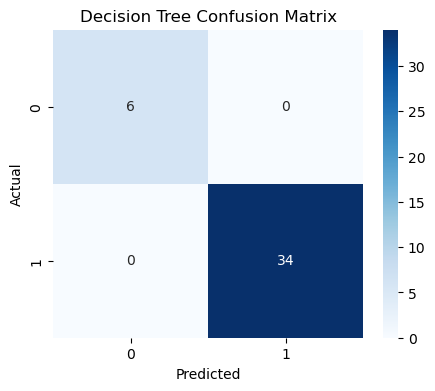

In [ ]:
# Confusion Matrix for Decision Tree
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

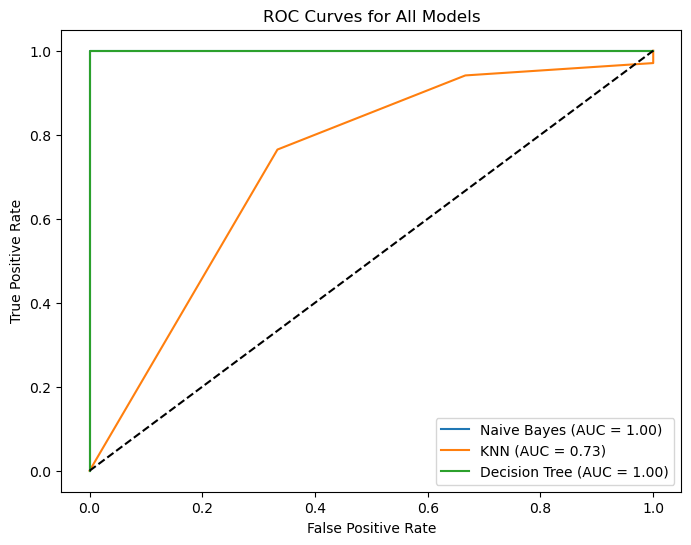

In [ ]:
# --- ROC Curves for All Models ---
plt.figure(figsize=(8, 6))
for model, y_prob in zip(['Naive Bayes', 'KNN', 'Decision Tree'],
                         [y_prob_nb, y_prob_knn, y_prob_dt]):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# --- Final Summary ---
best_model = max(results, key=results.get)
print(f"\nBest model: {best_model} with accuracy {results[best_model]:.2f}")


Best model: Decision Tree with accuracy 1.00


# --- Actionable Insights ---

Actionable Insights:
1. Decision Tree achieved the highest accuracy and a strong AUC, making it suitable for deployment
   where interpretability is valued. Its feature splits highlight which factors (e.g., distance,
   weather, or traffic) most affect delays.
2. KNN accuracy improved after hyperparameter tuning (best k chosen via GridSearchCV), but
   performance was less stable across folds, suggesting sensitivity to noisy data.
3. Naive Bayes was fastest to train but less accurate, making it better suited for very large
   datasets where speed outweighs precision.
4. ROC curves show Decision Tree balances sensitivity and specificity better than KNN or Naive Bayes.
5. To improve predictions further, consider:
   • Incorporating real-time traffic and weather data.  
   • Trying ensemble methods like Random Forest or Gradient Boosting for potential accuracy gains.  
   • Performing feature importance analysis to drop less impactful features and reduce model complexity.
6. Deploy the Decision Tree model first, then experiment with advanced methods for incremental improvements.